Earliest Start: {'A': 0, 'B': 3, 'C': 3, 'D': 7, 'E': 5, 'F': 12}
Earliest Finish: {'A': 3, 'B': 7, 'C': 5, 'D': 12, 'E': 8, 'F': 16}
Latest Start: {'F': 12, 'E': 9, 'D': 7, 'C': 7, 'B': 3, 'A': 0}
Latest Finish: {'F': 16, 'E': 12, 'D': 12, 'C': 9, 'B': 7, 'A': 3}
Slack: {'A': 0, 'B': 0, 'C': 4, 'D': 0, 'E': 4, 'F': 0}
Critical Path: ['A', 'B', 'D', 'F']
Project Duration: 16

PERT Expected Duration Example:
Expected Duration (o=3, m=4, p=5): 4.00 days


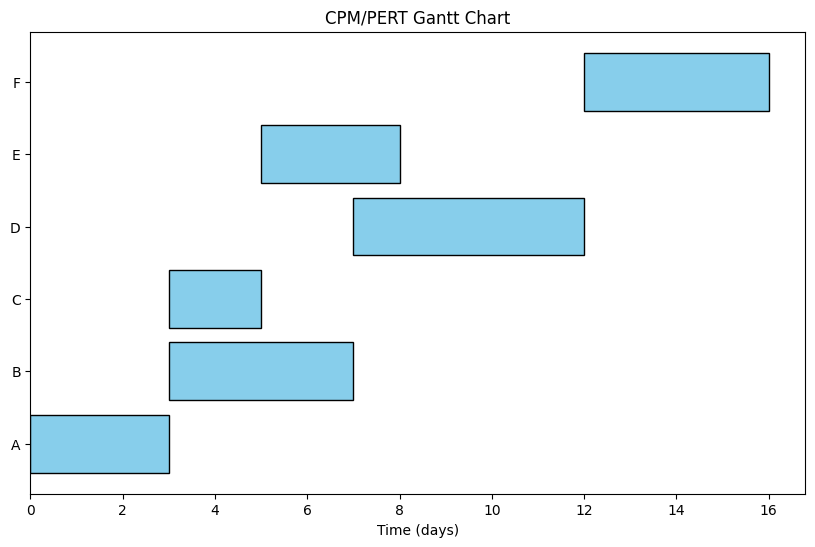

In [10]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

tasks = {
    'A': {'duration':3, 'deps':[]},
    'B': {'duration':4, 'deps':['A']},
    'C': {'duration':2, 'deps':['A']},
    'D': {'duration':5, 'deps':['B']},
    'E': {'duration':3, 'deps':['C']},
    'F': {'duration':4, 'deps':['D','E']}
}

task_names = list(tasks.keys())

def build_network(tasks):
    G = nx.DiGraph()
    for t in tasks:
        G.add_node(t)
        for dep in tasks[t]['deps']:
            G.add_edge(dep, t)
    return G


def forward_pass(G, tasks):
    ES, EF = {}, {}
    for task in nx.topological_sort(G):
        if not tasks[task]['deps']:
            ES[task] = 0
        else:
            ES[task] = max(EF[dep] for dep in tasks[task]['deps'])
        EF[task] = ES[task] + tasks[task]['duration']
    return ES, EF


def backward_pass(G, tasks, EF):
    LS, LF = {}, {}
    rev_order = list(nx.topological_sort(G))[::-1]
    project_duration = max(EF.values())
    for task in rev_order:
        successors = list(G.successors(task))  # convert iterator to list
        if len(successors) == 0:
            LF[task] = project_duration
        else:
            LF[task] = min(LS[succ] for succ in successors)
        LS[task] = LF[task] - tasks[task]['duration']
    return LS, LF


def compute_slack(ES, EF, LS, LF):
    slack = {task: LS[task]-ES[task] for task in task_names}
    critical_path = [task for task, s in slack.items() if s==0]
    return slack, critical_path


def pert_expected_duration(o, m, p):
    return (o + 4*m + p)/6


def plot_gantt(ES, EF):
    plt.figure(figsize=(10,6))
    for i, task in enumerate(task_names):
        plt.barh(i, EF[task]-ES[task], left=ES[task], color='skyblue', edgecolor='black')
    plt.yticks(range(len(task_names)), task_names)
    plt.xlabel('Time (days)')
    plt.title('CPM/PERT Gantt Chart')
    plt.show()


if __name__ == "__main__":
    G = build_network(tasks)
    ES, EF = forward_pass(G, tasks)
    LS, LF = backward_pass(G, tasks, EF)
    slack, critical_path = compute_slack(ES, EF, LS, LF)

    print("Earliest Start:", ES)
    print("Earliest Finish:", EF)
    print("Latest Start:", LS)
    print("Latest Finish:", LF)
    print("Slack:", slack)
    print("Critical Path:", critical_path)
    print("Project Duration:", max(EF.values()))

    # Optional: PERT example
    print("\nPERT Expected Duration Example:")
    o,m,p = 3,4,5
    print(f"Expected Duration (o={o}, m={m}, p={p}): {pert_expected_duration(o,m,p):.2f} days")

    # Plot Gantt Chart
    plot_gantt(ES, EF)



100%|██████████| 5000/5000 [00:00<00:00, 7614.36it/s]


Expected Project Duration: 68.20 days
95% Confidence Interval: [57.43, 81.59] days


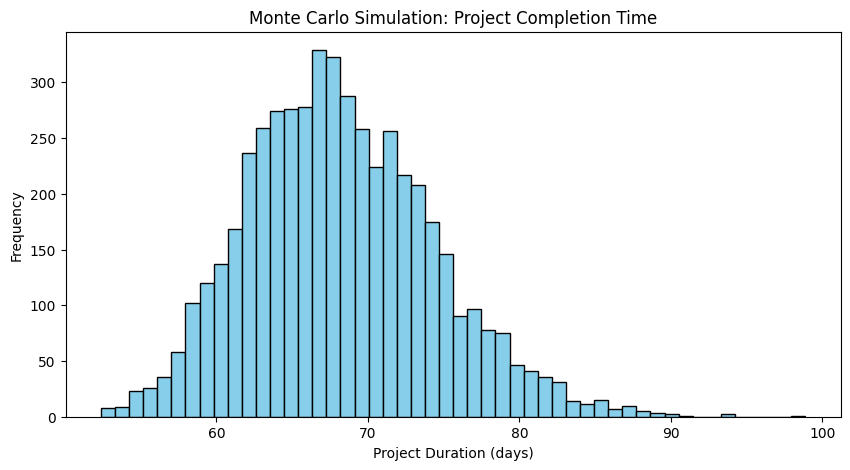

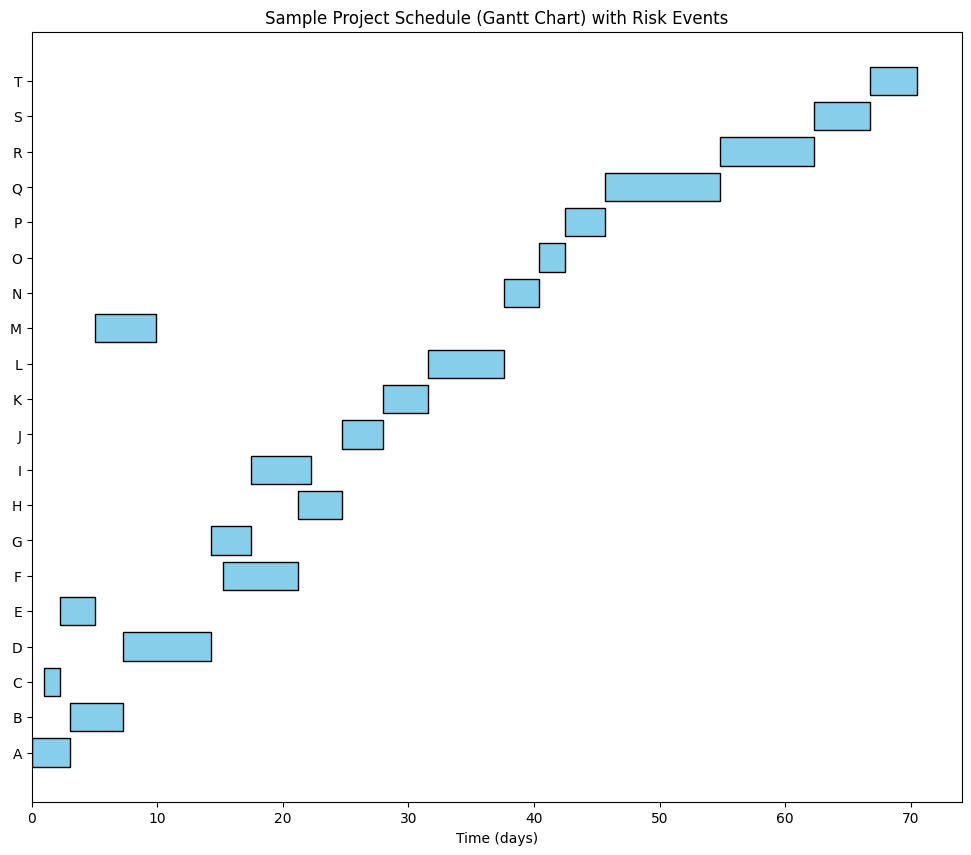

Task Sensitivity (Correlation with Project Duration):
T    0.293425
L    0.283253
R    0.279253
H    0.272122
A    0.271588
J    0.264930
B    0.263429
Q    0.263320
O    0.253482
P    0.250350
K    0.244903
N    0.240308
S    0.238898
D    0.234505
F    0.223946
G    0.074995
M    0.028188
I    0.025867
E    0.020279
C    0.005357
Name: Project_Duration, dtype: float64


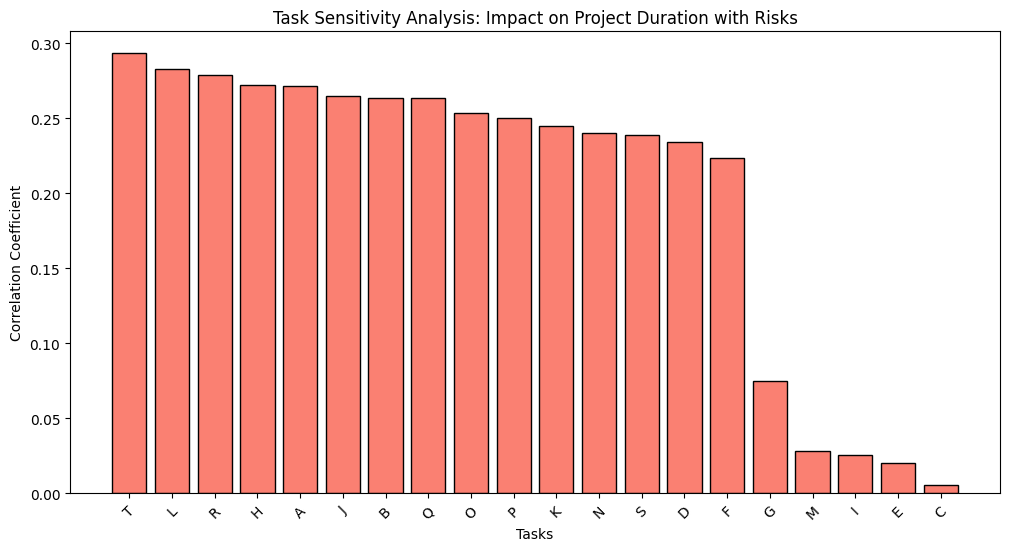

In [4]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import random


resources = {
    'Team1': 1,
    'Team2': 1,
    'Crane': 1
}

tasks = {
    # Phase 1: Foundation
    'A': {'duration':(2,3,4),'deps':[],'resource':'Team1'},
    'B': {'duration':(3,4,5),'deps':[('A','FS',0)],'resource':'Team1'},
    'C': {'duration':(1,2,3),'deps':[('A','SS',1)],'resource':'Team2'},
    'D': {'duration':(4,5,6),'deps':[('B','FS',0)],'resource':'Team1'},
    # Phase 2: Structure
    'E': {'duration':(2,3,4),'deps':[('C','FS',0)],'resource':'Team2'},
    'F': {'duration':(3,4,5),'deps':[('D','FS',1),('E','FF',0)],'resource':'Crane'},
    'G': {'duration':(2,3,4),'deps':[('C','SS',0)],'resource':'Team1'},
    'H': {'duration':(3,4,6),'deps':[('F','FS',0),('G','FS',0)],'resource':'Team2'},
    'I': {'duration':(1,2,3),'deps':[('G','FS',0)],'resource':'Team1'},
    # Phase 3: Finishing
    'J': {'duration':(2,3,4),'deps':[('H','FS',0)],'resource':'Crane'},
    'K': {'duration':(3,4,5),'deps':[('I','FS',0),('J','FS',0)],'resource':'Team2'},
    'L': {'duration':(2,3,4),'deps':[('K','FS',0)],'resource':'Team1'},
    'M': {'duration':(3,4,6),'deps':[('E','FS',0)],'resource':'Team2'},
    'N': {'duration':(2,3,4),'deps':[('M','FS',0),('L','FF',0)],'resource':'Team1'},
    # Phase 4: Utilities & Closing
    'O': {'duration':(1,2,3),'deps':[('N','FS',0)],'resource':'Crane'},
    'P': {'duration':(2,3,4),'deps':[('O','FS',0)],'resource':'Team1'},
    'Q': {'duration':(3,4,5),'deps':[('P','FS',0)],'resource':'Team2'},
    'R': {'duration':(2,3,4),'deps':[('Q','FS',0)],'resource':'Crane'},
    'S': {'duration':(3,4,5),'deps':[('R','FS',0)],'resource':'Team1'},
    'T': {'duration':(2,3,4),'deps':[('S','FS',0)],'resource':'Team2'}
}

task_names = sorted(tasks.keys())


risk_events = {
    'weather': {'prob':0.2, 'delay':(1,3)},
    'equipment': {'prob':0.1, 'delay':(2,5)},
    'labor': {'prob':0.15, 'delay':(1,2)}
}


def triangular_sample(o,m,p):
    return np.random.triangular(o,m,p)


def apply_risks(duration):
    total_delay = 0
    for risk in risk_events.values():
        if random.random() < risk['prob']:
            total_delay += random.randint(*risk['delay'])
    return duration + total_delay

def simulate_project(tasks, resources):
    start_times = {}
    finish_times = {}
    resource_calendar = {r:0 for r in resources}
    for task in nx.topological_sort(G):
        o,m,p = tasks[task]['duration']
        duration = triangular_sample(o,m,p)
        duration = apply_risks(duration)  # Add random risk delay
        deps = tasks[task]['deps']
        res = tasks[task]['resource']

        # Earliest start
        if not deps:
            est = 0
        else:
            times=[]
            for dep,dtype,lag in deps:
                if dtype=='FS':
                    times.append(finish_times[dep]+lag)
                elif dtype=='SS':
                    times.append(start_times[dep]+lag)
                elif dtype=='FF':
                    times.append(finish_times[dep]-duration+lag)
                elif dtype=='SF':
                    times.append(start_times[dep]-duration+lag)
            est = max(times)

        # Resource check
        available_time = resource_calendar[res]
        start_time = max(est, available_time)
        finish_time = start_time + duration
        start_times[task] = start_time
        finish_times[task] = finish_time
        resource_calendar[res] = finish_time

    return finish_times, start_times

G = nx.DiGraph()
for t in tasks:
    G.add_node(t)
    for dep,_,_ in tasks[t]['deps']:
        G.add_edge(dep,t)

n_sim = 5000
project_durations = []
all_task_durations = []

for _ in tqdm(range(n_sim)):
    finish, start = simulate_project(tasks, resources)
    project_durations.append(max(finish.values()))
    sim_durations = [finish[t]-start[t] for t in task_names]
    all_task_durations.append(sim_durations)

project_durations = np.array(project_durations)


print(f"Expected Project Duration: {project_durations.mean():.2f} days")
print(f"95% Confidence Interval: [{np.percentile(project_durations,2.5):.2f}, {np.percentile(project_durations,97.5):.2f}] days")

plt.figure(figsize=(10,5))
plt.hist(project_durations,bins=50,color='skyblue',edgecolor='black')
plt.title('Monte Carlo Simulation: Project Completion Time')
plt.xlabel('Project Duration (days)')
plt.ylabel('Frequency')
plt.show()


finish, start = simulate_project(tasks, resources)
plt.figure(figsize=(12,10))
yticks=[]
ylabels=[]
i=0
for task in task_names:
    plt.barh(i, finish[task]-start[task], left=start[task], color='skyblue', edgecolor='black')
    yticks.append(i)
    ylabels.append(task)
    i+=1
plt.yticks(yticks,ylabels)
plt.xlabel('Time (days)')
plt.title('Sample Project Schedule (Gantt Chart) with Risk Events')
plt.show()

df = pd.DataFrame(all_task_durations, columns=task_names)
df['Project_Duration'] = project_durations
correlation = df.corr()['Project_Duration'].drop('Project_Duration').sort_values(ascending=False)
print("Task Sensitivity (Correlation with Project Duration):")
print(correlation)

plt.figure(figsize=(12,6))
plt.bar(correlation.index, correlation.values, color='salmon', edgecolor='black')
plt.title('Task Sensitivity Analysis: Impact on Project Duration with Risks')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Tasks')
plt.xticks(rotation=45)
plt.show()


Critical Path Probability (%) for each task:
T: 100.00%
A: 0.00%
B: 0.00%
C: 0.00%
D: 0.00%
E: 0.00%
F: 0.00%
G: 0.00%
H: 0.00%
I: 0.00%
J: 0.00%
K: 0.00%
L: 0.00%
M: 0.00%
N: 0.00%
O: 0.00%
P: 0.00%
Q: 0.00%
R: 0.00%
S: 0.00%


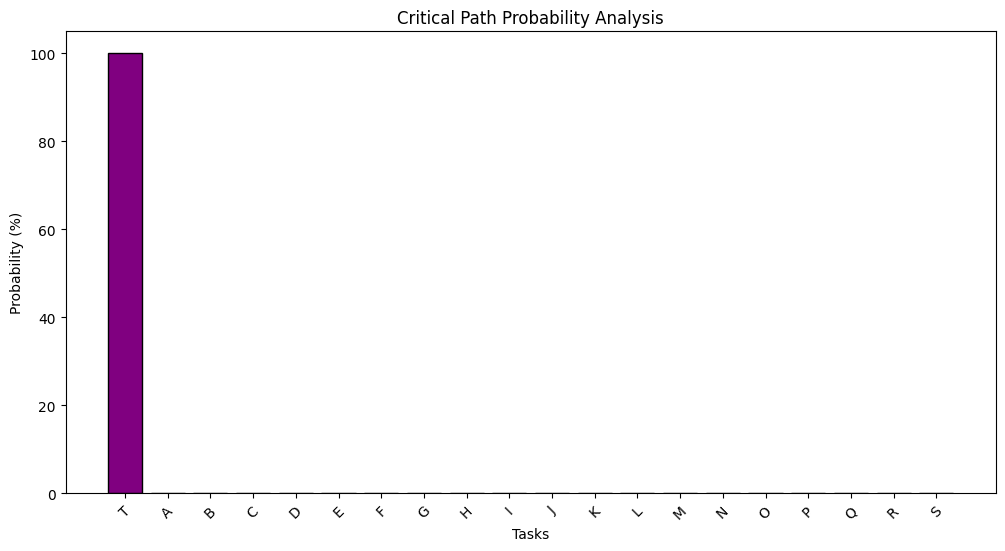

In [5]:
# ---------------------------
# Critical Path Probability Analysis
# ---------------------------
critical_counts = {t:0 for t in task_names}

for i in range(n_sim):
    finish, start = simulate_project(tasks, resources)
    project_duration = max(finish.values())

    # Slack for each task
    slack = {}
    for task in task_names:
        # Max finish time from task to end of project
        remaining = project_duration - finish[task]
        slack[task] = remaining

    # Tasks with zero slack are critical
    for task, s in slack.items():
        if s == 0:
            critical_counts[task] += 1

# Convert to percentage
critical_prob = {t: critical_counts[t]/n_sim*100 for t in task_names}

# Sort for visualization
critical_prob = dict(sorted(critical_prob.items(), key=lambda x: x[1], reverse=True))
print("Critical Path Probability (%) for each task:")
for t, prob in critical_prob.items():
    print(f"{t}: {prob:.2f}%")

# Plot
plt.figure(figsize=(12,6))
plt.bar(critical_prob.keys(), critical_prob.values(), color='purple', edgecolor='black')
plt.title('Critical Path Probability Analysis')
plt.ylabel('Probability (%)')
plt.xlabel('Tasks')
plt.xticks(rotation=45)
plt.show()


100%|██████████| 5000/5000 [00:00<00:00, 5060.15it/s]


Expected Project Duration: 68.22 days
95% Confidence Interval: [57.49, 81.59] days


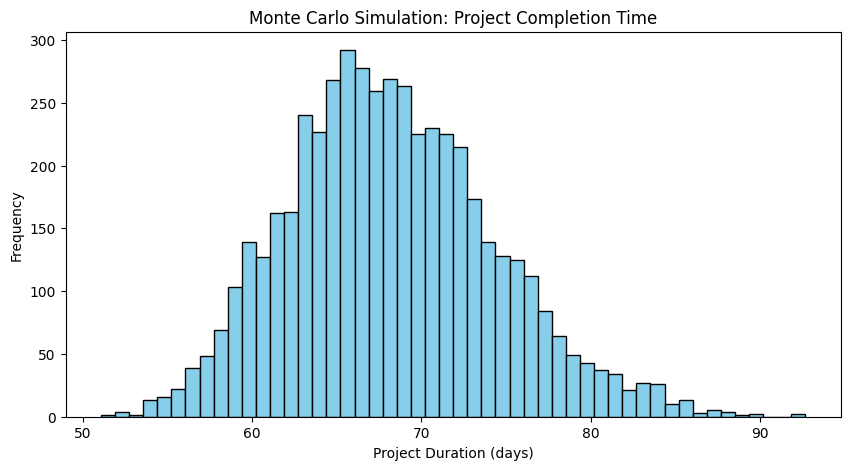

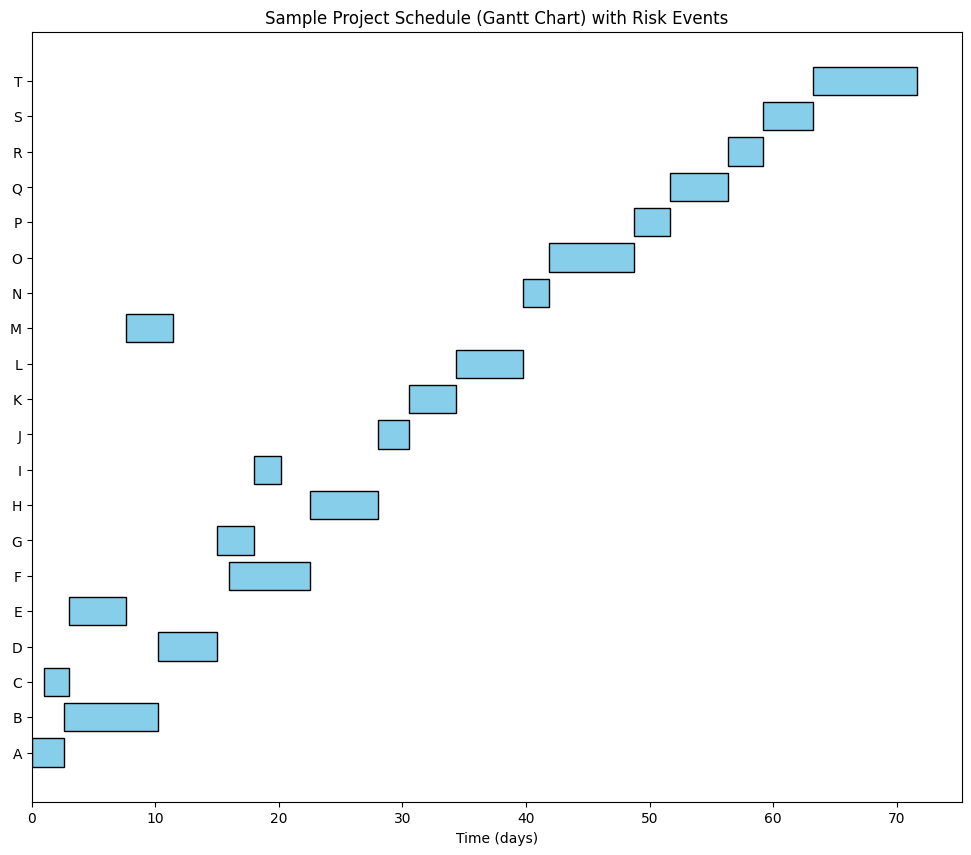

Task Sensitivity (Correlation with Project Duration):
S    0.286475
Q    0.286406
T    0.271179
N    0.264576
O    0.262975
P    0.259579
D    0.255953
K    0.253798
J    0.252322
L    0.251008
H    0.250946
F    0.243963
R    0.243265
B    0.240759
A    0.233435
G    0.062802
M    0.029948
C    0.016121
E    0.013462
I   -0.024308
Name: Project_Duration, dtype: float64


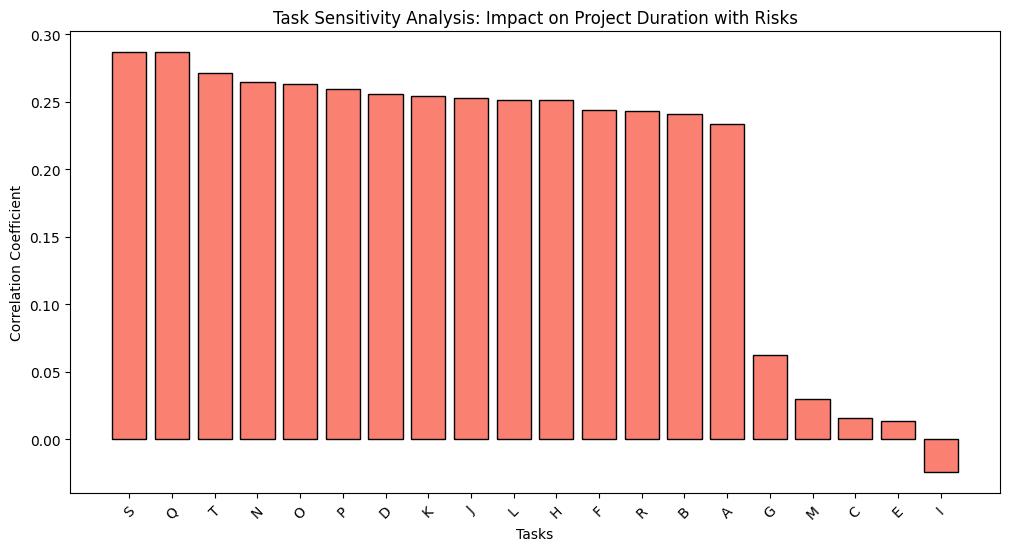

In [11]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

resources = {
    'Team1': 1,
    'Team2': 1,
    'Crane': 1
}


tasks = {
    'A': {'duration':(2,3,4),'deps':[],'resource':'Team1'},
    'B': {'duration':(3,4,5),'deps':[('A','FS',0)],'resource':'Team1'},
    'C': {'duration':(1,2,3),'deps':[('A','SS',1)],'resource':'Team2'},
    'D': {'duration':(4,5,6),'deps':[('B','FS',0)],'resource':'Team1'},
    'E': {'duration':(2,3,4),'deps':[('C','FS',0)],'resource':'Team2'},
    'F': {'duration':(3,4,5),'deps':[('D','FS',1),('E','FF',0)],'resource':'Crane'},
    'G': {'duration':(2,3,4),'deps':[('C','SS',0)],'resource':'Team1'},
    'H': {'duration':(3,4,6),'deps':[('F','FS',0),('G','FS',0)],'resource':'Team2'},
    'I': {'duration':(1,2,3),'deps':[('G','FS',0)],'resource':'Team1'},
    'J': {'duration':(2,3,4),'deps':[('H','FS',0)],'resource':'Crane'},
    'K': {'duration':(3,4,5),'deps':[('I','FS',0),('J','FS',0)],'resource':'Team2'},
    'L': {'duration':(2,3,4),'deps':[('K','FS',0)],'resource':'Team1'},
    'M': {'duration':(3,4,6),'deps':[('E','FS',0)],'resource':'Team2'},
    'N': {'duration':(2,3,4),'deps':[('M','FS',0),('L','FF',0)],'resource':'Team1'},
    'O': {'duration':(1,2,3),'deps':[('N','FS',0)],'resource':'Crane'},
    'P': {'duration':(2,3,4),'deps':[('O','FS',0)],'resource':'Team1'},
    'Q': {'duration':(3,4,5),'deps':[('P','FS',0)],'resource':'Team2'},
    'R': {'duration':(2,3,4),'deps':[('Q','FS',0)],'resource':'Crane'},
    'S': {'duration':(3,4,5),'deps':[('R','FS',0)],'resource':'Team1'},
    'T': {'duration':(2,3,4),'deps':[('S','FS',0)],'resource':'Team2'}
}
task_names = sorted(tasks.keys())


risk_events = {
    'weather': {'prob':0.2, 'delay':(1,3)},
    'equipment': {'prob':0.1, 'delay':(2,5)},
    'labor': {'prob':0.15, 'delay':(1,2)}
}


def triangular_sample(o,m,p):
    return np.random.triangular(o,m,p)

def apply_risks(duration):
    total_delay = 0
    for risk in risk_events.values():
        if random.random() < risk['prob']:
            total_delay += random.randint(*risk['delay'])
    return duration + total_delay


def build_network(tasks):
    G = nx.DiGraph()
    for t in tasks:
        G.add_node(t)
        for dep,_,_ in tasks[t]['deps']:
            G.add_edge(dep, t)
    return G


def simulate_project(tasks, resources, G):
    start_times = {}
    finish_times = {}
    resource_calendar = {r:0 for r in resources}
    for task in nx.topological_sort(G):
        o,m,p = tasks[task]['duration']
        duration = triangular_sample(o,m,p)
        duration = apply_risks(duration)
        deps = tasks[task]['deps']
        res = tasks[task]['resource']

        if not deps:
            est = 0
        else:
            times=[]
            for dep,dtype,lag in deps:
                if dtype=='FS':
                    times.append(finish_times[dep]+lag)
                elif dtype=='SS':
                    times.append(start_times[dep]+lag)
                elif dtype=='FF':
                    times.append(finish_times[dep]-duration+lag)
                elif dtype=='SF':
                    times.append(start_times[dep]-duration+lag)
            est = max(times)

        available_time = resource_calendar[res]
        start_time = max(est, available_time)
        finish_time = start_time + duration
        start_times[task] = start_time
        finish_times[task] = finish_time
        resource_calendar[res] = finish_time

    return finish_times, start_times


def monte_carlo_simulation(tasks, resources, n_sim=5000):
    G = build_network(tasks)
    project_durations = []
    all_task_durations = []
    for _ in tqdm(range(n_sim)):
        finish, start = simulate_project(tasks, resources, G)
        project_durations.append(max(finish.values()))
        sim_durations = [finish[t]-start[t] for t in task_names]
        all_task_durations.append(sim_durations)
    return np.array(project_durations), pd.DataFrame(all_task_durations, columns=task_names), G

def visualize_results(project_durations, all_task_df, tasks, resources, G):
    print(f"Expected Project Duration: {project_durations.mean():.2f} days")
    print(f"95% Confidence Interval: [{np.percentile(project_durations,2.5):.2f}, {np.percentile(project_durations,97.5):.2f}] days")

    # Histogram
    plt.figure(figsize=(10,5))
    plt.hist(project_durations,bins=50,color='skyblue',edgecolor='black')
    plt.title('Monte Carlo Simulation: Project Completion Time')
    plt.xlabel('Project Duration (days)')
    plt.ylabel('Frequency')
    plt.show()

    # Gantt Chart: one sample
    finish, start = simulate_project(tasks, resources, G)
    plt.figure(figsize=(12,10))
    for i, task in enumerate(sorted(tasks.keys())):
        plt.barh(i, finish[task]-start[task], left=start[task], color='skyblue', edgecolor='black')
    plt.yticks(range(len(tasks)), sorted(tasks.keys()))
    plt.xlabel('Time (days)')
    plt.title('Sample Project Schedule (Gantt Chart) with Risk Events')
    plt.show()

    # Sensitivity Analysis
    all_task_df['Project_Duration'] = project_durations
    correlation = all_task_df.corr()['Project_Duration'].drop('Project_Duration').sort_values(ascending=False)
    print("Task Sensitivity (Correlation with Project Duration):")
    print(correlation)

    plt.figure(figsize=(12,6))
    plt.bar(correlation.index, correlation.values, color='salmon', edgecolor='black')
    plt.title('Task Sensitivity Analysis: Impact on Project Duration with Risks')
    plt.ylabel('Correlation Coefficient')
    plt.xlabel('Tasks')
    plt.xticks(rotation=45)
    plt.show()


if __name__ == "__main__":
    project_durations, all_task_df, G = monte_carlo_simulation(tasks, resources, n_sim=5000)
    visualize_results(project_durations, all_task_df, tasks, resources, G)
